In [1]:
# importing once and for all the needed stuff...
import gzip, os, sys, cPickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize as optimize
from scipy.stats import norm as Gaussian_PDF
from my_foos import Lin_Log_Bins, Smooth_Curve, p_n_pow_const, Power_Growth

from matplotlib import rc
rc('font', family = 'serif', serif = 'Times')
rc('text', usetex = True)
from matplotlib.ticker import NullFormatter

%pylab inline
%matplotlib inline

sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in",\
    "xtick.major.size": 10, "ytick.major.size": 10,\
    "xtick.minor.size": 5,  "ytick.minor.size": 5,})

# Colors and plot-related stuff...
colori = ['#F44E21', '#28CE9A', '#1A91E2', '#585959','#BF2D19', '#A3CD39', '#39D5F1',\
        '#7F5271',  '#FF9A15', '#068C7F', '#206584', '#8CBBEA']
markers = ('o', '8', '^', '<', 'D', '*', 's', 'p', 'v', 'h', 'H', '>', 'd')

cmap_winter = matplotlib.cm.winter
cmap_autumn = matplotlib.cm.autumn
cmap_summer = matplotlib.cm.summer
cmap_spring = matplotlib.cm.spring
cmap_rb = matplotlib.cm.rainbow

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## If you want to analyze the data, here you go...

In [2]:
import Network_Importer as NII

In [3]:
if False: #"PRL"
    dat_file_name = NII.Network_Importer("../../data/APS/data/data_company_like/L_60/",\
        "../../out/Prova_new_importer_PRL/", SOC_THR=0, step_by_step=False, n_t_smpl=50, starting_time=48,\
        time_events=False, zipped_f=False, act_bins_factor=1.2, deg_bins_factor=1.4)
elif False: #"TWT"
    dat_file_name = NII.Network_Importer("../../data/twitter/twitter/data-01-09_company_like/",\
        "../../out/Prova_new_importer_TWT_new/", SOC_THR=0, step_by_step=False, n_t_smpl=50,\
        time_events=True, zipped_f=False, act_bins_factor=1.3, deg_bins_factor=1.3)
elif True: #"APS" TOTAL
    dat_file_name = NII.Network_Importer("../../data/APS/aff_data_ISI_company_like_1960_2008/",\
        "../../out/APS_TOTAL/", SOC_THR=0, step_by_step=False, n_t_smpl=20, starting_time=1033,\
        time_events=False, zipped_f=False, act_bins_factor=1.25, deg_bins_factor=1.25, binning='act')
    

Reference file:  1960-01_deca0.dat
Last file:  2008-01_deca0.dat
read the first line:  ['704', '164483', '1', '1']
No reference time found in reference file, continuing...
First round, file 1659 of 1659...

Total Network:

Total Nodes: 1.846e+05
Company Nodes: 1.846e+05
Edges: 9.959e+05
Events: 3.371e+06

Social Network:

Threshold: 00
Nodes: 1.846e+05
Company Nodes: 1.846e+05
Edges: 9.959e+05
Events: 3.371e+06
DEBUG n_act_bins = 16
DEBUG n_t0s_bins = 10
DEBUG: in act class 00   --- kmin 0001 --- kmax 0002 --- nkbins 01
	Bins:  [ 0.5  2.5]
DEBUG: in act class 01   --- kmin 0001 --- kmax 0004 --- nkbins 02
	Bins:  [ 0.5  2.5  4.5]
DEBUG: in act class 02   --- kmin 0001 --- kmax 0007 --- nkbins 04
	Bins:  [ 0.5  2.5  4.5  6.5  7.5]
DEBUG: in act class 03   --- kmin 0001 --- kmax 0011 --- nkbins 04
	Bins:  [  0.5   2.5   4.5   7.5  11.5]
DEBUG: in act class 04   --- kmin 0001 --- kmax 0018 --- nkbins 06
	Bins:  [  0.5   2.5   4.5   6.5   8.5  12.5  18.5]
DEBUG: in act class 05   --- kmin 

## Loading data...

First define the datafile to use as *dat_file_name*...

In [4]:
dat_file_name

'../../out/APS_TOTAL/00/data/DATA__p-000-1659_thres_00_a16_actbin_integrated_tfil_tsmp-20.dat'

In [5]:
if False:
    dat_file_name =\
        '../../out/APS_TOTAL/00/data/DATA__p-000-1659_thres_00_a30_t0sbin_integrated_tfil_tsmp-20.dat'

DATA = cPickle.load(gzip.open(dat_file_name, 'rb'))

In [6]:
# Creating the needed dirs...
needed_dirs = ["P_akt", "kat", "pna", "chi_square"]
#####################################

BASE_DIR = os.path.split(os.path.split(dat_file_name)[0])[0]
for dirn in needed_dirs:
    tmp_path = os.path.join(BASE_DIR, dirn)
    if not (os.path.exists(tmp_path) and os.path.isdir(tmp_path)):
        os.mkdir(tmp_path)

## The $p(k)$ reinforcement process

In [7]:
################################################
# Threshold: a point must have at least thres-events, thres new events and
# a difference between the two of at least thres to be accounted for...
Threshold = 10

# Minimum number of valid points for a curve to be fitted...
Nmin = 5

# Factor smooting the curves...
smooth_factor = lambda v: (float(max(v))/max(1., min(v)))*.099

# Plotting settings...
print_legend = True
markers_size = 10
ax_fsize, lbl_fsize, lgnd_fsize = 16, 22, 10
figsize=(5,4)
################################################

# Here we save all the curves for the later fitting procedure and heat-map...
Pn_Curves = {}
pna = DATA['ACT']['P_N_A']

for act_class, Res in sorted(pna.items()):
    some_plot = False
    fig_tmp = plt.figure(figsize=figsize)
    for deg_bin, pni in Res.items():
        
        valid_degs = [k for k, evs in sorted(pni.items())\
                     if evs['s_new'] >= Threshold and evs['s_eve'] >= Threshold\
                     and (evs['s_eve'] - evs['s_new']) >= Threshold\
                     and float(k) <= (DATA['ACT']['Bins']['kk'][act_class][deg_bin])]
        
        X = np.array([float(k) for k in valid_degs])
        Y = np.array([float(pni[k]['s_new'])/float(pni[k]['s_eve']) for k in valid_degs])
        
        # Cleaning the zeroes...
        X = X[Y>.0]
        Y = Y[Y>.0]
        
        # Computing the uncertainity on the measured $p(k)$...
        STD_err = np.array([((Y[i]*(1.-Y[i]))/float(pni[k]['s_eve']))**.5\
                            for i,k in enumerate(valid_degs)])
        
        if len(X) > Nmin:
            some_plot = True
            X_plot, Y_plot = Smooth_Curve(X, Y, factor=smooth_factor(X))
            plt.loglog(X_plot,Y_plot, '--', marker=markers[deg_bin%len(markers)], ms=markers_size,\
                       label="%02d"%deg_bin, alpha=.9)
            
            Pn_Curves.setdefault(act_class, {})
            Pn_Curves[act_class].setdefault(deg_bin, {'x': X, 'y': Y, 'w': STD_err,\
                                                      'x_smooth': X_plot, 'y_smooth': Y_plot})
            
    if some_plot:
        plt.xticks(size=ax_fsize)
        plt.yticks(size=ax_fsize)
        plt.xlabel(r"$k$", size=lbl_fsize)
        plt.ylabel(r"$p(k\to k+1)$", size=lbl_fsize)

        if print_legend: plt.legend(loc=1, fontsize=lgnd_fsize, ncol=1)

        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR, "pna/p_n_%02d.pdf" % act_class), bbox_inches='tight')
    
    plt.close(fig_tmp)

In [8]:
################################################
# Select a single multi-activity, non fitted curves...

selectedMultiAs = [10, 13]

some_plot = False
fig_tmp = plt.figure(figsize=figsize)
for act_class, deg_class in sorted(Pn_Curves.items()):
    if act_class not in selectedMultiAs:
        continue
        
    for deg_bin, pni in sorted(deg_class.items()):
        if deg_bin in [12, 13]:
            continue
        print deg_bin
        some_plot = True
        
        X_plot, Y_plot = pni["x_smooth"], pni["y_smooth"]

        plt.loglog(X_plot,Y_plot, '--', marker=markers[(act_class + act_class*deg_bin)%len(markers)],
                   ms=markers_size, alpha=.9)

if some_plot:
    plt.xticks(size=ax_fsize)
    plt.yticks(size=ax_fsize)
    plt.xlabel(r"$k$", size=lbl_fsize)
    plt.ylabel(r"$p(k)$", size=lbl_fsize)

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "pna/p_n_multiA_%s.pdf" % "_".join(["%02d"%ac for ac in selectedMultiAs])),
                bbox_inches='tight')

plt.close(fig_tmp)

1
2
3
4
0
1
2
3
4
5


## Now we compute the optimal $\beta$, then plotting the fitted $p(k\to k+1)$ with the total rescaled one...

In [9]:
################################################
# Beta interval to sweep...
Beta_int = np.arange(.0, 3.01, .01)

# Fixed beta overall or use the optimal beta for each bin...
Fixed_Beta = True

# setting bounds for c...
const_bounds = (1e-4, 1e+4)

# Plotting stuff...
Show_Legend = True
n_points_Pc = 8

################################################

Tot_Chi_Sums = np.zeros(len(Beta_int), dtype=float)
opt_pars = {b:{ak:{dk:[] for dk in act_dic.keys()} for ak,act_dic in Pn_Curves.items()} for b in Beta_int}
Chi_Sums = {b:{ak:{dk:.0 for dk in act_dic.keys()} for ak,act_dic in Pn_Curves.items()} for b in Beta_int}

for ii_ind, bb_val in enumerate(Beta_int):
    opt_params = np.array([bb_val, 2.])
    opt_bounds = [(bb_val*.9999, bb_val*1.0001), const_bounds]

    sum_chi_temp, sum_pop_temp, pts_pop_temp = .0, .0, .0
    for ak, act_dic in sorted(Pn_Curves.items()):
        for dk, deg_dic in sorted(act_dic.items()):
            nn = deg_dic['x']
            pn = deg_dic['y']
            wn = deg_dic['w']

            par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(p_n_pow_const, x0 = opt_params,\
                    args=(nn, pn, wn), bounds=opt_bounds, approx_grad=True,\
                    maxfun=1000000, maxiter=1000000)
            
            print "\rOptimization for bin a%02d-k%02d done with exit status %d: beta %.02f - cnst %.02f - chi2 %.02e"%\
                (ak,dk,dic_out['warnflag'], par_out[0], par_out[1], chi2_tmp),

            # Saving the summed chi square...
            sum_chi_temp += chi2_tmp
            sum_pop_temp += DATA['TOT']['N_A_K'][ak][dk]
            pts_pop_temp += float(len(nn) - 1)

            # Saving the constant and the chi_squared...
            opt_pars[bb_val][ak][dk] = [v for v in par_out]
            Chi_Sums[bb_val][ak][dk] = chi2_tmp

    if sum_pop_temp != .0:
        # We normalize by the number of fitted points, indeed this will be
        # the same number for every beta (we always fit the same curves!).
        Tot_Chi_Sums[ii_ind] = sum_chi_temp/pts_pop_temp
        #chi_sums[ii_ind] = sum_chi_temp/sum_pop_temp
        #chi_sums[ii_ind] = sum_chi_temp/sum_pop_temp/pps_pop_temp
print "\n"

Ind_Bopt = np.argmin(Tot_Chi_Sums)
Beta_Opt = Beta_int[Ind_Bopt]
print 'beta_opt_act=%.02f' % Beta_Opt

Optimization for bin a14-k04 done with exit status 0: beta 3.00 - cnst 1593.27 - chi2 1.11e+02 

beta_opt_act=0.13


In [10]:
##################################################
# Now plotting the distribution of the optimized #
# constant for each activity class...            #
##################################################

fig_Pconst = plt.figure()

# The containers for the cumulative (overall) distribution of P(c)...
TOT_cs = []
TOT_ns = []

# Saving here, once and for all, the optimal beta for each bin...
Optimal_Beta_bin = {ak: {dk: {} for dk in act_dic.keys()} for ak, act_dic in Pn_Curves.items()}

for ak in sorted(Pn_Curves.keys()):
    # Using the optimal beta or the optimal beta for each sk-dk bin depending on our choice...
    if Fixed_Beta:
        for dk in Pn_Curves[ak].keys(): Optimal_Beta_bin[ak][dk] = {'beta': Beta_Opt, 'beta_indx': Ind_Bopt}
    else:
        for dk in Pn_Curves[ak].keys():
            ref_indx = np.argmin([Chi_Sums[b][ak][dk] for b in Beta_int])
            Optimal_Beta_bin[ak][dk] = {'beta': Beta_int[ref_indx], 'beta_indx': ref_indx}
        
    # Saving the constants and population of each bin for the tmp plot and the general one...
    consts = np.array([opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][1]\
                       for dk in sorted(Pn_Curves[ak].keys())])
    populs = np.array([float(DATA['TOT']['N_A_K'][ak][dk]) for dk in sorted(Pn_Curves[ak].keys())])
    TOT_cs.extend(consts)
    TOT_ns.extend(populs)
    
    if len(np.unique(consts)) > 1:
        Y, X = np.histogram(consts, weights=populs, density=True, bins=\
            np.logspace(np.log10(max(const_bounds[0],consts.min())),\
            np.log10(min(const_bounds[1],consts.max())), n_points_Pc))
    else:
        X, Y = np.array([consts[0]*.999, consts[0]*1.001]), np.ones(1) # since consts has only one value...
    
    X = X[1:] + X[:-1]
    X /= 2.
    X = X[Y>.0]
    Y = Y[Y>.0]
    
    plt.loglog(X, Y,'--', alpha=.8, marker=markers[ak%len(markers)], label="%02d"%ak)

# Then plotting the overall distribution...
YY, XX = np.histogram(TOT_cs, weights=TOT_ns, density=True, bins=\
    np.logspace(np.log10(max(const_bounds[0],min(TOT_cs))), np.log10(min(const_bounds[1],max(TOT_cs))), n_points_Pc))
XX = XX[1:] + XX[:-1]
XX /= 2.
XX = XX[YY>.0]
YY = YY[YY>.0]

plt.loglog(XX, YY, '-', lw=4, color='#068C7F', label='All')

if Show_Legend:
    plt.legend(loc=3, fontsize=lgnd_fsize, ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'chi_square/P_c.pdf'), bbox_inches='tight')
plt.close(fig_Pconst)

In [11]:
##################################################
# Now plotting the fitted p(n) for each activity #
# class and the total rescaled plot...           #
##################################################

# Selected activity classes for the overall rescaled p(k) function...
Sel_acts = range(4, 16, 2)

########################################################

fig_pn_tot = plt.figure(1, figsize=figsize)
resc_lim = [1000, .01]
for ak, act_dic in sorted(Pn_Curves.items()):
    fig_tmp = plt.figure(2, figsize=figsize)
    for dk, pni in sorted(act_dic.items()):
        if dk in []:
            continue
        fig_tmp = plt.figure(2)
        serie_tmp = plt.loglog(pni['x_smooth'], pni['y_smooth'],\
                   linestyle='', marker=markers[dk%len(markers)], ms=markers_size, alpha=.9)
        
        XX = np.logspace(.0, np.log10(max(pni['x'])), 50)
        plt.loglog(XX, p_n_pow_const(opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk], XX),\
                   '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())
        
        if ak in Sel_acts:
            plt.figure(1)
            XX = pni['x_smooth']/opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][1]
            YY = pni['y_smooth']**(1./opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][0])
            plt.loglog(XX, YY, marker=markers[(ak*(dk+1))%len(markers)], ms=markers_size, alpha=.9)
            if max(XX) > resc_lim[1]: resc_lim[1] = max(XX)
            if min(XX) < resc_lim[0]: resc_lim[0] = min(XX)
            
    plt.figure(2)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'pna/p_n_fit_%02d.pdf' % ak), bbox_inches='tight')
    plt.close(fig_tmp)

plt.figure(1)
XXX = np.logspace(np.floor(np.log10(resc_lim[0])), np.ceil(np.log10(resc_lim[1])), 100)
plt.loglog(XXX, 1./(1. + XXX), '-k', lw=4, alpha=.85, label=r"$(1+x)^{-1}$")

plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$x=k/c_i$", size=lbl_fsize)
plt.ylabel(r"$p(x)^{1/\beta}$", size=lbl_fsize)

plt.legend(loc=3, fontsize=lbl_fsize, ncol=1)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'pna/all_p_n.pdf'), bbox_inches='tight')
plt.close(fig_pn_tot)

In [12]:
##################################################
# Now plotting the fitted p(n) for a selected    #
# activity class with single beta for each bin.  #
##################################################

# Selected activity classes for the overall rescaled p(k) function...
Sel_act = 8
Discarded_ks = []

########################################################

fig_pn_tot = plt.figure(1, figsize=figsize)
fig_tmp = plt.figure(2, figsize=figsize)
act_dic = Pn_Curves[Sel_act]
FirstPlot = True
for dk, pni in sorted(act_dic.items()):
    print dk
    if dk in Discarded_ks:
        continue
        
    label = r"$\beta = " if FirstPlot else r"  $"
    if FirstPlot: FirstPlot = False
    label += r"%.01f$" % Optimal_Beta_bin[Sel_act][dk]['beta']
    
    serie_tmp = plt.loglog(pni['x_smooth'], pni['y_smooth'],\
               linestyle='', marker=markers[dk%len(markers)], ms=markers_size, alpha=.9, label=label)

    
    XX = np.logspace(.0, np.log10(max(pni['x'])), 50)
    
    
    plt.loglog(XX, p_n_pow_const(opt_pars[Optimal_Beta_bin[Sel_act][dk]['beta']][Sel_act][dk], XX),\
               '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())

plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$k$", size=lbl_fsize)
plt.ylabel(r"$p(k)$", size=lbl_fsize)

frame = plt.legend(loc=3, fontsize=(lbl_fsize*4/5), ncol=4, handlelength=.25, numpoints=1,\
          columnspacing=.5, handletextpad=.7, framealpha=1., frameon=True)
frame = frame.get_frame()
frame.set_color('white')
frame.set_facecolor('white')
frame.set_edgecolor('white')

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'pna/p_n_fit_bs_%02d.pdf' % Sel_act), bbox_inches='tight')
plt.close()

1
2
3
4
5


## ... and now the heatmap with bands...

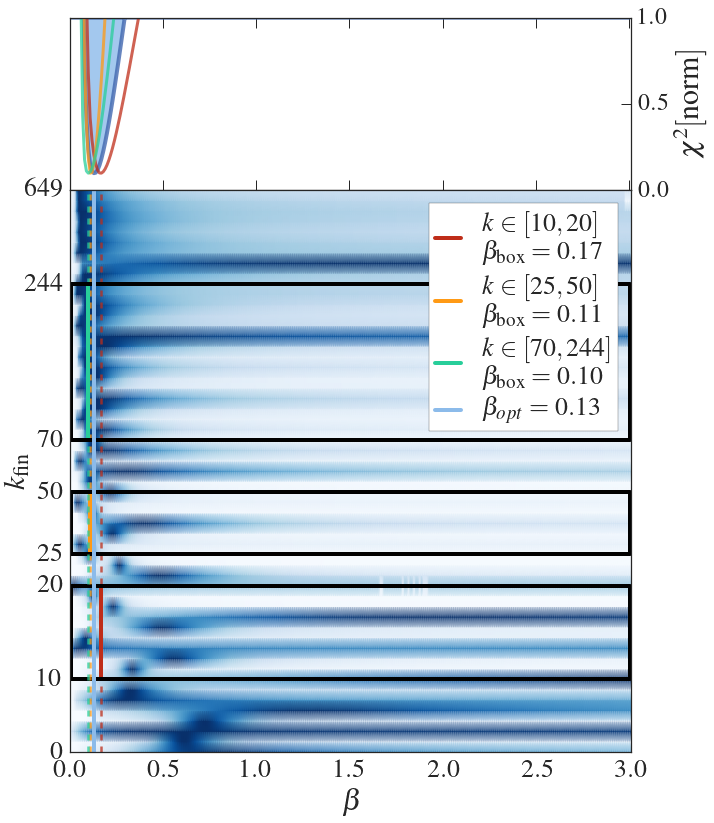

In [13]:
######################################
# The boxes to show the various betas...
#Boxes_lim = [[10,20], [40,80]] # PRA
#Boxes_lim = [[10,20], [25,50], [70, 300]] # PRB
#Boxes_lim = [[10,20], [20, 50]] # PRD
#Boxes_lim = [[7,15], [15,60]] # PRE
#Boxes_lim = [[10,20], [20,150]] # PRL
#Boxes_lim = [[10,25], [30,60], [80, 400]] # TWT
#Boxes_lim = [[10,20], [30,60], [90, 294]] # MPN
Boxes_lim = [[10,20], [25,50], [70, 244]] # APS entrance

# Whether or not to plot a guide to the eye...
Plot_Diag = False
diag_beta = [2.4, 1.2]
diag_degs = [0, 293]

# The program will rescale the curves between ValMin and ValMax so
# as to compare them...
ValMax = 1.
ValMin = .1

######################################
#Plot stuff (here we have a little more things ;) )
###################################### You should not touch the stuff here :)
left, bottom, width, height = .1, .1, .65, .65 # The rectangulum position and size for the HM
bottom_h = bottom + height
rect_HM = [left, bottom, width, height]
rect_X2 = [left, bottom_h, width, .2]

fig_tot = plt.figure(1, figsize=(12,12))
axX2 = plt.axes(rect_X2)
axX2.xaxis.set_major_formatter(NullFormatter())
axHM = plt.axes(rect_HM)

CMPS = ['Oranges', 'Reds', 'Greens']
Colors = ['#BF2D19', '#FF9A15', '#28CE9A']
Color_Tot = '#8CBBEA'
###################################### End of plot stuff...
Map_Original = np.zeros((sum([len(act_dic) for act_dic in Chi_Sums[Beta_int[0]].values()]), len(Beta_int)),\
                        dtype=float)
Kmins = np.zeros(Map_Original.shape[0], dtype=float)
row = 0
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm, Normalize
for ak, act_dic in Chi_Sums[Beta_int[0]].items():
    for dk, deg_dic in act_dic.items():
        Map_Original[row] = np.array([Chi_Sums[bb][ak][dk] for bb in Beta_int])
        Kmins[row] = DATA['ACT']['Bins']['kk'][ak][dk]
        row += 1
ISkmin = np.argsort(Kmins)
Map_Original = Map_Original[ISkmin][:]
Kmins = Kmins[ISkmin]

DeltaVal = ValMax - ValMin

if False:
    # Now rescale the map so that the curves are comparable...
    # Lower the minimum to zero for all the rows...
    Map_Rescaled = Map_Original - np.array([[min_row]*Map_Original.shape[1] for min_row in Map_Original.min(axis=1)])
    # Set 1. as a reference in the far right of the map for each row...
    Map_Rescaled /= np.array([[row[-5] if row[-5]>row_val else 1. for row_val in row] for row in Map_Rescaled])
    # Rescale and shift...
    Map_Rescaled *= DeltaVal
    Map_Rescaled += ValMin
    Map_Rescaled = -np.log10(Map_Rescaled)
else:
    Map_Rescaled = Map_Original / np.array([[min_row]*Map_Original.shape[1] for min_row in Map_Original.min(axis=1)])
    Map_Rescaled **= -1.
    

#figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')
figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')

#axHM.plot([300, 120], [0, len(Kmins)], '--', lw=5, alpha=.9, color='#FCDD2B')

#plt.colorbar(figHM)

tot_chi2_curve = Tot_Chi_Sums/Tot_Chi_Sums.min()/1.1
tot_chi2_curve -= min(tot_chi2_curve) - .1
axX2.fill_between(np.arange(len(Beta_int)), tot_chi2_curve, 1.,\
                color=Color_Tot, lw=4, alpha=.8, edgecolor='#4167af')

y_labels = [(0,0), (len(Kmins)-1, Kmins[-1])]
for boxi, box_edges in enumerate(Boxes_lim):
    if box_edges[0] < Kmins[0] or box_edges[1] > Kmins[-1]:
        print "Ignoring box ", box_edges, " because it is out of bound: kmin = %d, kmax = %d" % (Kmins[0], Kmins[-1])
        continue
    tmp_chi2_curve = Map_Original[(Kmins>=box_edges[0]) & (Kmins<=box_edges[1])].sum(axis=0)
    tmp_chi2_curve /= tmp_chi2_curve.min()*1.1
    tmp_chi2_curve -= tmp_chi2_curve.min() - .1
    axX2.plot(np.arange(len(Beta_int)), tmp_chi2_curve,\
                     color=Colors[boxi], lw=3, alpha=.75)
    
    
    # The reference curve and the black box...
    box_bot = np.argmax(Kmins>=box_edges[0])
    box_top = np.argmin(Kmins<=box_edges[1])
    min_ind = np.argmin(tmp_chi2_curve)
    axHM.plot([min_ind]*2, [0, Map_Original.shape[0]-1], '--',\
              color=Colors[boxi], lw=2.5, alpha=.75)
    axHM.plot([min_ind]*2, [box_bot, box_top], '-', color=Colors[boxi],\
              lw=4, label=r'$k\in[%d, %d]$' '\n' r'$\beta_{\rm box}=%.02f$'%\
             (box_edges[0], box_edges[1], Beta_int[min_ind]))
    axHM.plot([1.,1.,len(Beta_int)-1.5, len(Beta_int)-1.5, 1.],\
        [box_bot, box_top, box_top, box_bot, box_bot], '-k', lw=4)
    
    y_labels.extend([(box_bot, box_edges[0]), (box_top, box_edges[1])])

if Plot_Diag:
    axHM.plot([np.argmax(Beta_int >= b) for b in diag_beta], [np.argmax(Kmins >= k) for k in diag_degs],\
              '--', lw=5, alpha=.9, color='#FCDD2B')
    
beta_labels = range(0, len(Beta_int), 50)
axHM.xaxis.set_ticks(beta_labels, minor=True)
axHM.xaxis.set_ticklabels([r"$%.01f$"%Beta_int[i] for i in beta_labels], size=26)
#axHM.xaxis.set_tick_params(which='both', direction='in', length=12, width=10, zorder=0)

axHM.set_yticks([ylab[0] for ylab in y_labels])
axHM.set_yticklabels([r"$%d$"%ylab[1] for ylab in y_labels], size=26)
    
axHM.plot([Ind_Bopt]*2, [0, len(Kmins)-1],\
        '-', color=Color_Tot, lw=4,\
        label=r'$\beta_{opt} = %.02f$' % (Beta_Opt))



axX2.set_ylim(0,1)
axX2.set_xlim(0,len(Beta_int))
#axHM.legend(fontsize=26, loc=3, bbox_to_anchor=(.00125,.00125), frameon=True, borderpad=.25, labelspacing=.25, handlelength=1.)
axHM.legend(fontsize=26, loc=1, frameon=True, borderpad=.25, labelspacing=.25, handlelength=1.)
axHM.set_ylim(0, len(Kmins)-1)
axHM.set_xlabel(r"$\beta$", size=30)
axHM.set_ylabel(r"$k_{\rm fin}$", size=30, labelpad=-10)


axX2.yaxis.tick_right()
axX2.axes.set_yticks([0., .5, 1.])
axX2.axes.set_yticklabels([r'$%.1f$' % c2v for c2v in [.0, .5, 1.]], size=24)
axX2.set_ylabel(r"$\chi^2[{\rm norm}]$", size=30)
axX2.yaxis.set_label_position("right")

fig_tot.savefig(os.path.join(BASE_DIR, "chi_square/Heat_Map_Bands.pdf"))#, bbox_inces="tight")

In [14]:
Beta_int

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
        0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
        0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
        0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
        0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
        0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,
        0.99,  1.  ,  1.01,  1.02,  1.03,  1.04,  1.05,  1.06,  1.07,
        1.08,  1.09,  1.1 ,  1.11,  1.12,  1.13,  1.14,  1.15,  1.16,
        1.17,  1.18,  1.19,  1.2 ,  1.21,  1.22,  1.23,  1.24,  1.25,
        1.26,  1.27,

# ... now the $P(a,k,t)$...

    - Choose the activity classes to plot;
    - choose the time of reference;
    - choose the scaling picture expected (if no parameters are found);
    - select the times to be plotted as well...

In [26]:
Act_classes = [2, 3, 4, 5, 6, 7, 8, 10, 14, 18, 20, 22, 26 ] # Between 0 and a** as reported in the file name...

Reference_time = "evnt"     # Either 'evnt' for event time, 'fnum' for file number or
                            # 'real' for the time of the analysis (uses real time if it was specified in the files);

Scaling_scheme = "SupBR"    # 'SupBR' for alpha > (2beta+2)/(2beta+1) (poissonian scheme),
                            # 'WBR' for weak burstiness regime, and
                            # 'StrBR' for alpha < 1.0;

Times = range(0, 20, 2)     # The indexes of the TVec to be considered...

#########################################

        
# Selecting the reference time...
if Reference_time == "evnt":
    ref_time = DATA['TOT']['ev_t']
elif Reference_time == 'fnum':
    ref_time = DATA['TOT']['fn_t']
elif Reference_time == 'real':
    ref_time = DATA['TOT']['re_t']

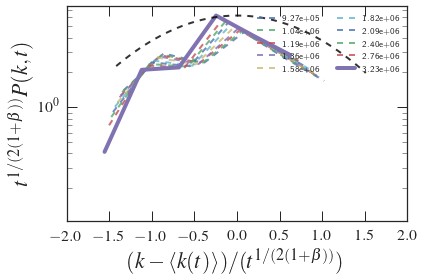

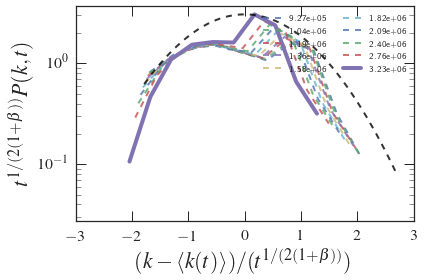

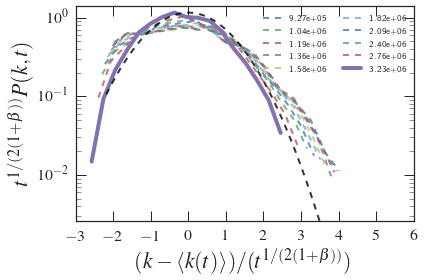

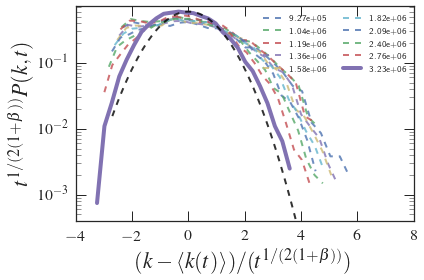

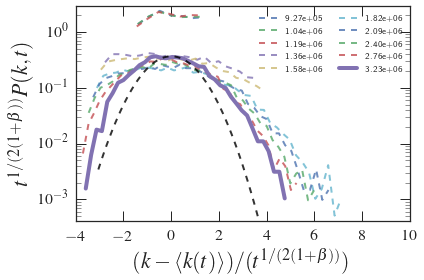

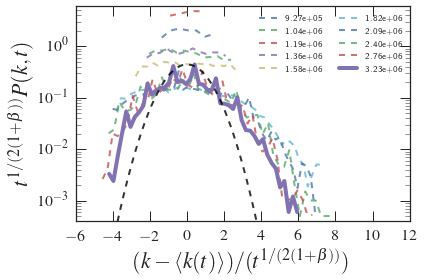

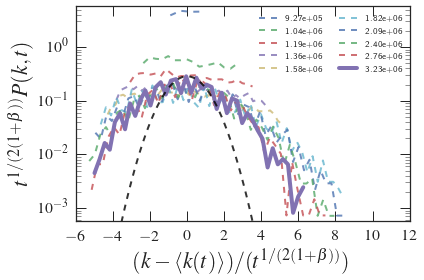

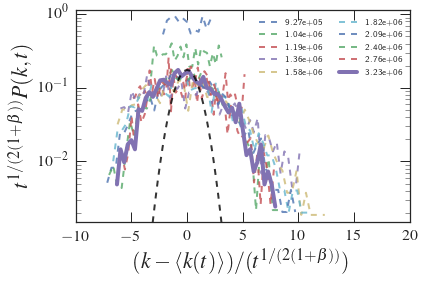

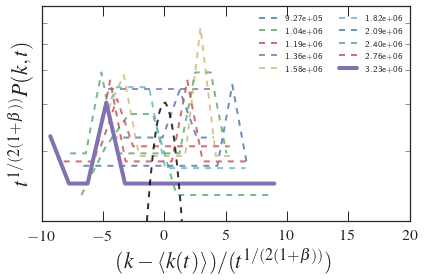

In [27]:
Pakt = DATA['ACT']['P_akt']
for act_class in [a for a in Act_classes if a in Pakt]:
    try:
        plt.figure()

        Res = Pakt[act_class]

        k_min, k_max, y_min, y_max = 10000., .001, 1e+8, 1e-8

        valid_times = [t for t in Times if t in Res]
        max_time = max(valid_times)

        for time in valid_times:

            v = Res[time]

            ks = np.array(v["k"], dtype=float)
            ns = np.array(v["n"], dtype=int)

            if True:
                peak = ks[ns.argmax()]
                max_k = peak*3.
                ns = ns[ks < max_k]
                ks = ks[ks < max_k]

            avg_k = (ks*ns).sum()/ns.sum()

            if Scaling_scheme == "SupBR":
                bins = np.linspace(ks[0], ks[-1], max(50,min(int(ks.max()/ks.min()), 30)))
            else:
                bins = Lin_Log_Bins(max(1., ks[0]), max(2., ks[-1]), factor=1.25)

            freq, bins = np.histogram(ks, weights=ns, bins=bins, density=True)

            ks = bins[1:]+bins[:-1]
            ks /= 2.

            ks = ks[freq > .0]
            freq = freq[freq > .0]

            X = ks
            Y = freq

            if Scaling_scheme == "SupBR":
                X -= avg_k
                X /= np.sqrt(avg_k)

                Y *= np.sqrt(avg_k)

                X_plot, Y_plot = Smooth_Curve(X, Y, binning="lin", factor=1.)

                if max(Y_plot) > .0:
                    if time == max_time:
                        plt.semilogy(X_plot,Y_plot,label="%.02e"%ref_time[time], lw=4)
                    else:
                        plt.semilogy(X_plot,Y_plot,label="%.02e"%ref_time[time], lw=2, alpha=.8, linestyle='--')
            else:
                X /= np.sqrt(avg_k)

                Y *= np.sqrt(avg_k)

                plt.semilogy(X,Y,label="%.02e"%ref_time[time])
            if X.min() < k_min: k_min = X.min()
            if X.max() > k_max: k_max = X.max()
            if Y.min() < y_min: y_min = Y.min()
            if Y.max() > y_max: y_max = Y.max()

        Distrib_tmp = Gaussian_PDF((X*Y).mean(), (X*Y).std())
        X_tmp = np.linspace(k_min*.8, k_max*1.2, 100)
        Y_tmp = Gaussian_PDF.pdf(X_tmp)
        Y_tmp *= Y.max()/Y_tmp.max()
        plt.plot(X_tmp, Y_tmp, '--k', lw=2, alpha=.8)

        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlabel(r"$\tilde k = \frac{k^{1+\beta}}{(1+\beta)t^\alpha}$", size=22)
        plt.ylabel(r"$\frac{\tilde k}{1+\beta}P(a,k,t)$", size=22)

        Alpha = 18

        if Alpha <= 1.:
            plt.xlabel(r"$k / t^{\alpha/(1+\beta)}$", size=22)
            plt.ylabel(r"$t^{\alpha/(1+\beta)} P(k,t)$", size=22)
        elif (1<Alpha<= 2.) and (not Gaussian):
            plt.xlabel(r"$(k-\langle k(t)\rangle)/t^{\frac{1}{\alpha}-\frac{1}{(1+\beta)}}$", size=22)
            plt.ylabel(r"$t^{\frac{1}{\alpha}-\frac{1}{(1+\beta)}} P(k,t)$", size=22)
        else:
            plt.xlabel(r"$(k-\langle k(t)\rangle)/(t^{1/(2(1+\beta))})$", size=22)
            plt.ylabel(r"$t^{1/(2(1+\beta))} P(k,t)$", size=22)

        plt.ylim(y_min*.8, y_max*1.2)
        #plt.xlim(-10,10)

        plt.legend(loc=1, fontsize=9, ncol=2)

        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR, "P_akt/Pakt_%02d.pdf" % act_class), bbox_inches='tight')
    except Exception as E:
        print str(E)

216 153


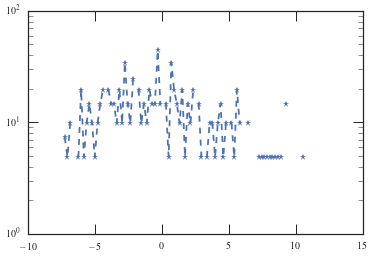

In [17]:
a = 12
t = 19
xxx = np.array(Pakt[a][t]["k"])
yyy = np.array(Pakt[a][t]["n"])
mean = (xxx*yyy).sum()/yyy.sum()
peak = xxx[yyy.argmax()]

yyy = yyy[xxx<mean*2]
xxx = xxx[xxx<mean*2]

print mean, peak

X, Y = Smooth_Curve((xxx-mean)/mean**.5, yyy*mean**.5, binning="lin", factor=3.)
plt.semilogy(X, Y, '*--')


## The $\langle k(a,t)\rangle_a$...

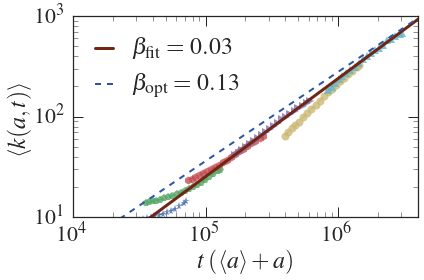

In [25]:
################################################
# Select the activity classes to plot...
Act_classes = range(5, 26, 2)

# Fitting classes to account...
act_from, act_to = -2, len(Act_classes)
fit_from = 12.2515e+5

# plotting the fit from to, moving it by...
fit_plot_interval, fit_offset = np.logspace(3.75, 7), 2.

# x axis limit (set to None for free plot)
xlim = (1e4, 4e6)
ylim = (1e1, 1e3)
################################################

kat = DATA['ACT']['k_a_t']

acts = np.array(DATA['TOT']['Vectors']['aa'])
max_act = acts.max()
acts /= max_act
avg_act = acts.sum()/len(acts)

plt.figure()

valid_classes = [a for a in Act_classes if a in kat]
Fit_X, Fit_Y = [], []
for act_class in valid_classes:
    # kat[act_class]
    act_tmp = (DATA['ACT']['Bins']['aa'][act_class] + DATA['ACT']['Bins']['aa'][act_class+1])/2./max_act
    kat_tmp = kat[act_class]
    
    X = np.array([ref_time[i] for i in sorted(kat_tmp.keys())])
    Y = np.array([kat_tmp[i] for i in sorted(kat_tmp.keys())])
    
    X *= act_tmp + avg_act
    
    plt.loglog(X, Y, '--', marker=markers[act_class%len(markers)], ms=8, alpha=.8, lw=1.5)#, label="%02d"%act_class)
    
    if act_class in valid_classes[act_from:act_to]:
        Fit_X.extend(X[X>=fit_from])
        Fit_Y.extend(Y[X>=fit_from])

par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., .5, 1e-6],\
        args=(Fit_X, Fit_Y), bounds=[(1e-8, 1e+8), (0.025, .975), (.0, 1e-4)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)
plt.loglog(fit_plot_interval, .5*fit_offset*Power_Growth(par_out, fit_plot_interval), '-',\
           label=r"$\beta_{\rm fit}=%.02f$"%(1./par_out[1]-1.), color="#702515", lw=3)

par_out_theor, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., 1./(1.+Beta_Opt), 1e-6],\
        args=(Fit_X, Fit_Y), bounds=[(1e-8, 1e+8), (1./(1.+Beta_Opt)*.9999, 1./(1.+Beta_Opt)*1.0001), (.0, 1e-4)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)
plt.loglog(fit_plot_interval, .55*fit_offset*Power_Growth(par_out_theor, fit_plot_interval), '--',\
           label=r"$\beta_{\rm opt}=%.02f$"%Beta_Opt, color="#2c55a3", lw=2)

plt.xticks(size=22)
plt.yticks(size=22)
plt.xlabel(r"$t \left(\langle a\rangle + a\right)$", size=24)
plt.ylabel(r"$\langle k(a,t)\rangle$", size=24)

if True:
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

plt.legend(loc=2, fontsize=24, ncol=1, handlelength=.75)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/kat_%s.pdf" % (Reference_time)), bbox_inches='tight')

In [19]:
print np.min(Map_Rescaled), np.max(Map_Rescaled)

0.000190453839579 1.0


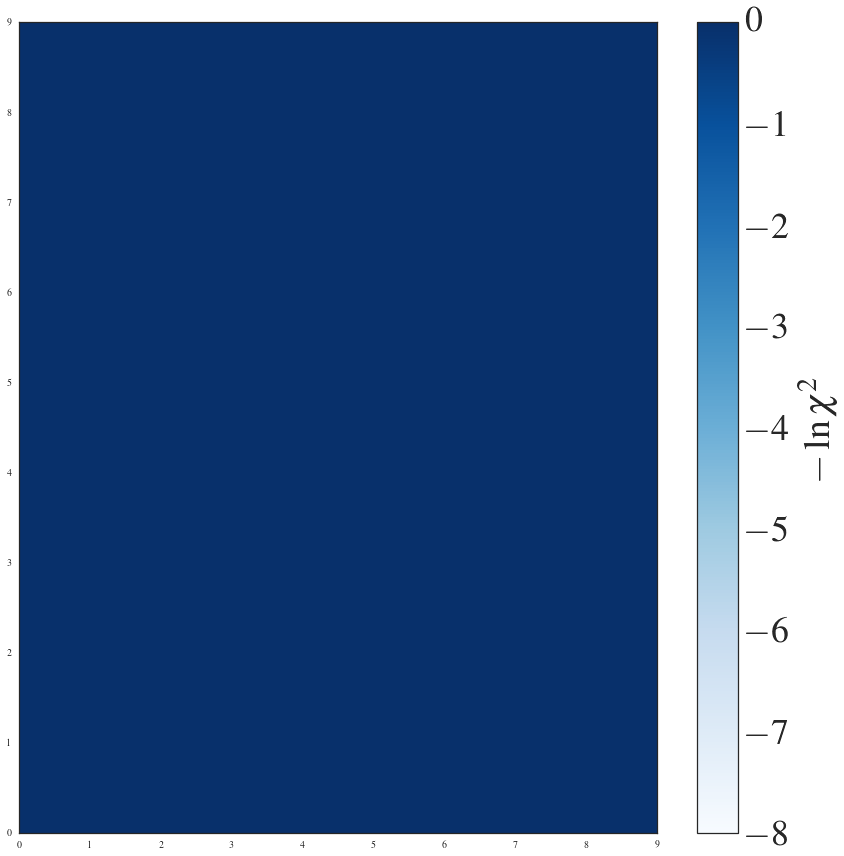

In [20]:
plt.figure(figsize=(12,12))

figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')
plt.pcolormesh(1./(np.random.rand(10,10)*DeltaVal+ValMin), cmap='Blues',\
               norm=Normalize(), edgecolors='none', shading='gouraud', vmin=.2, vmax=1.)
#plt.colorbar(ticks=np.linspace(1.0, 10.0))#, format="%.01f")

minimo = 8
cb = plt.colorbar(ticks=np.linspace(.2, 1.0, minimo+1))
font_size = 36 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
cb.set_ticklabels([r"$%d$" %(-minimo+d) for d in range(minimo+1)])
cb.set_label(r"$-\ln{\chi^2}$", size=38)

plt.tight_layout()
plt.savefig("Colorbar.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(12,12))

plt.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')
cb = plt.colorbar()
font_size = 36 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
#cb.set_ticklabels([r"$%d$" %(-minimo+d) for d in range(minimo+1)])
cb.set_label(r"$\chi^2_{\rm opt}(b)/\chi^2_b(\beta)$", size=38)

plt.tight_layout()
plt.savefig("Colorbar.pdf", bbox_inches="tight")

In [ ]:
print cb.values

In [ ]:
X = np.logspace(0, np.log10(30), 60)
Y = np.linspace(1, 30, 59)
plt.loglog(X, Y, ".b")

X_m = X[1:] + X[:-1]
X_m /= 2.
plt.loglog(X_m, Y, "sk")

X_l = np.array([np.logspace(np.log10(X[i]), np.log10(X[i+1]), 5)[1] for i in range(len(X)-1)])
plt.loglog(X_l, Y, "*r")

In [ ]:
np.logspace(0,1,3)